## Multivariable linear regression
### Create the data

In [2]:
# create the data set
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
plt.style.use('seaborn-darkgrid')

num_features = 2
data_points = 1000
beta_set = 2.*np.random.normal(size=num_features)
alpha_set = np.random.normal(size=1)

X = np.random.normal(size=(data_points, num_features))
y = alpha_set + np.sum(beta_set*X, axis=1) + np.random.normal(size=(data_points))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Plot the data set

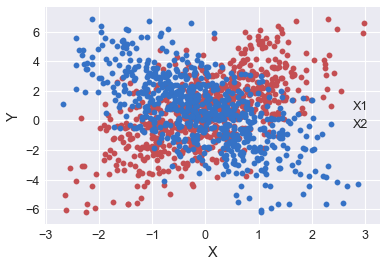

In [3]:
plt.scatter(X_train[:,0], y_train, c='r', label='X1')
plt.scatter(X_train[:,1], y_train, c='b', label='X2')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Create the pymc3 model 

In [ ]:
lin_reg_model = pm.Model()  #instantiate the pymc3 model object

#Create a shared theano variable. This allows the model to be created using the X_train/y_train data 
# and then test with the X_test/y_test data
model_input = theano.shared(X_train)
model_output = theano.shared(y_train)

with lin_reg_model:
    alpha = pm.Normal('alpha', mu=0, sd=1, shape= (1)) # create random variable alpha of shape 1
    beta = pm.Normal('betas', mu=0, sd=1, shape=(1,num_features)) # create random variable beta of shape 1,num_features
    
    s = pm.HalfNormal('s', sd=1)  # create distribution to describe noise in the data
    
    data_est = alpha + theano.tensor.dot(beta, model_input.T)  # Expected value of outcome
    
    y = pm.Normal('y', mu=data_est, sd=s, observed=y_train)  # Likelihood (sampling distribution) of observations

### Train the model

In [ ]:
with lin_reg_model:
    step = pm.NUTS()
    nuts_trace = pm.sample(2000, step, njobs=1)

### traceplot and summary statistics

In [ ]:
plt.style.use('seaborn-darkgrid')
pm.traceplot(nuts_trace)
plt.show()

In [ ]:
pm.summary(nuts_trace[1000:])

### Test the trained model on the test data

In [ ]:
# set the shared values to the test data
model_input.set_value(X_test)
model_output.set_value(y_test)

#create a posterior predictive check (ppc) to sample the space of test x values
ppc = pm.sample_ppc(
        nuts_trace[1000:], # specify the trace and exclude the first 1000 samples 
        model=lin_reg_model, # specify the trained model
        samples=1000) #for each point in X_test, create 1000 samples

### Plot the y_test vs y_predict and calculate r**2

In [ ]:
pred = ppc['y'].mean(axis=0)  # take the mean value of the 1000 samples at each X_test value 
plt.scatter(y_test, pred)
plt.show()
r2_score(y_test,*pred)

In [146]:
beta.shape

Shape.0

In [153]:
data_est.eval(model_input.T)

AttributeError: 'TensorVariable' object has no attribute 'keys'

In [155]:
y_train

array([ 1.28302775e+00, -3.93031394e-01, -4.01046626e+00, -7.71477163e-01,
       -2.00581929e-02, -2.08906296e+00,  1.87352810e+00, -4.20136128e+00,
        9.35106042e-01, -6.77825836e-01,  3.27595719e-01,  6.84400951e+00,
       -9.38731853e-01, -1.38973405e+00,  1.68243377e+00, -3.80529593e-01,
        9.11935007e-01, -3.68421883e+00, -1.18039700e+00,  7.55839159e-01,
        1.04778799e+00,  2.67222127e+00, -1.57949476e+00, -2.34830949e+00,
        1.61811587e+00,  2.42945708e+00,  2.63267345e+00,  1.60690177e+00,
        2.32464482e-01, -2.13026674e+00,  1.82151408e+00, -4.14640843e+00,
       -1.93050086e+00, -6.34164026e-01, -1.99245425e+00,  2.58961701e+00,
        3.18168574e+00, -5.27939954e-01, -6.26468660e-01, -1.50468791e+00,
        9.10118238e-01,  1.05045918e+00,  7.70984473e-01, -3.37170240e-01,
        2.28412632e-01,  4.65835649e+00,  2.31238432e+00,  3.96575202e+00,
       -4.25154413e-01,  2.32623458e+00, -2.06796363e+00, -1.40520094e+00,
       -2.30151407e+00,  

In [5]:
y_train.shape

(670,)